# Config

In [1]:
ff_rob_using = True
max_sentence_size = 512

# 1. Initial imports

In [ ]:
!pip install transformers==4.5.0
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.7/212.7 kB 15.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tokenizers
Failed to build tokenizers
ERROR: Could not build wheels for tokenizers, which is required to install pyproject.toml-based projects
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# to import files from googledrive
from google.colab import drive
if not ff_rob_using:
  drive.mount('/content/drive', force_remount=True)
else:
  drive.mount('/content/drive/', force_remount=True)
  sample_size_dir = 'drive/MyDrive/Sample size for NLP'


In [ ]:
import os

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC #JC
from sklearn.ensemble import RandomForestClassifier #JC
from sklearn.neighbors import KNeighborsClassifier #JC
from sklearn.naive_bayes import GaussianNB #JC
from sklearn.tree import DecisionTreeClassifier #JC
from sklearn.svm import SVC #JC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, precision_score, recall_score, precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc, roc_auc_score

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer #JC

#for word embedding
import gensim
from gensim.models import Word2Vec #Word2Vec is mostly used for huge datasets
import time
import logging

In [ ]:
def time_code():
    def decorate(func):
        def call(*args, **kwargs):
            print('Entered function %s' % func.__name__)
            start = time.time()
            result = func(*args, **kwargs)
            end = time.time()
            func_time = end - start
            print('Exiting function %s - took %.2f seconds' % (func.__name__, func_time))
            return result
        return call
    return decorate

# 2. Data for Classification

Load the data for classification

In [ ]:
@time_code()
def get_data_for_classifier():
  if not ff_rob_using:
    path = '/content/drive/My Drive/Sample size for NLP/Sample_Size_Saniya'
  else:
    path = '%s/Sample_Size_Saniya' % sample_size_dir
  return pd.read_csv(path+'/12k_data_for_classifier.csv')#



# 3. Split data into different sample sizes and proportions



In [ ]:
@time_code()
def get_train_test_split(full_data_for_classfier, num_train_samples, portion_of_positive, num_test_samples):

  num_samples = num_train_samples + num_test_samples
  assert(0 < num_samples <= 12000)
  assert(0 < portion_of_positive < 1)

  portion_of_negative = 1 - portion_of_positive
  ss0 = int(num_samples*portion_of_negative)
  ss1 = int(num_samples*portion_of_positive)

  s0 = full_data_for_classfier.label[full_data_for_classfier.label.eq(0)].sample(ss0).index
  s1 = full_data_for_classfier.label[full_data_for_classfier.label.eq(1)].sample(ss1).index

  data_for_classifier = full_data_for_classfier.loc[s0.union(s1)]

  test_size = num_test_samples / num_samples
  training_data, testing_data = train_test_split(data_for_classifier, test_size=test_size, random_state=1)
  return training_data, testing_data



In [ ]:
@time_code()
def get_balanced_cross_fold_train_test_split(
    full_data_for_classifier: pd.DataFrame,
    cross_folds: int,
    ):
  assert(1 < cross_folds)

  positive_samples = int(len(full_data_for_classifier) / 2)
  negative_samples = int(len(full_data_for_classifier) / 2)

  all_positive = full_data_for_classifier.loc[full_data_for_classifier.label[full_data_for_classifier.label.eq(0)].sample(positive_samples).index]
  all_negative = full_data_for_classifier.loc[full_data_for_classifier.label[full_data_for_classifier.label.eq(1)].sample(negative_samples).index]

  positive_buckets = np.array_split(all_positive, cross_folds)
  negative_buckets = np.array_split(all_negative, cross_folds)

  for test_bucket_index in range(cross_folds):

    test_positive = positive_buckets[test_bucket_index]
    test_negative = negative_buckets[test_bucket_index]

    train_positive = pd.concat([pb for pd_index,pb in enumerate(positive_buckets) if pd_index is not test_bucket_index])
    train_negative = pd.concat([pb for pd_index,pb in enumerate(negative_buckets) if pd_index is not test_bucket_index])

    train = pd.concat([train_positive, train_negative])
    test = pd.concat([test_positive, test_negative])

    yield train, test


###############################################################################
###################### REST OF THIS CELL IS JUST TESTING ######################
###############################################################################
# Do some testing on the cross folds and make sure that we aren't putting
# the same samples into different train test datasets
cross_fold_indexes = {}
for cross_fold_index, (train, test) in enumerate(get_balanced_cross_fold_train_test_split(get_data_for_classifier(), 5)):
  cross_fold_indexes[cross_fold_index] = {
      'train': list(train.index),
      'test': list(test.index),
  }


for cross_fold_index in range(5):
  # Make sure the train and test set when unions is equal to the total number of samples
  length = len(set(cross_fold_indexes[cross_fold_index]['train']).union(set(cross_fold_indexes[cross_fold_index]['test'])))
  assert(length == 12000)

  if cross_fold_index == 0:
    common_train = set(cross_fold_indexes[cross_fold_index]['train'])
    all_test = set(cross_fold_indexes[cross_fold_index]['test'])
  else:
    common_train = common_train - set(cross_fold_indexes[cross_fold_index]['train'])
    all_test = all_test.union(cross_fold_indexes[cross_fold_index]['test'])

assert(len(common_train) == 0)
assert(len(all_test) == 12000)

# 4. BERT Classification

# BERT imports

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

In [ ]:
from collections import Counter
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.model_selection import StratifiedKFold
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset
from tqdm import trange
from transformers import BertForSequenceClassification, BertTokenizerFast, BertTokenizer, AdamW, AutoModel, AutoModelForSequenceClassification, AutoTokenizer

In [ ]:
from transformers import BertTokenizer, AutoTokenizer
@time_code()
def get_tokenizer(pretrained_string: str, padding_side :str, truncate_side :str, do_lower_case: bool):
# Load the BERT tokenizer.
  print('Loading BERT tokenizer...')
  tokenizer = BertTokenizer.from_pretrained(pretrained_string,
                                            padding_side=padding_side,
                                            do_lower_case=do_lower_case,
                                            truncation_side=truncate_side) #bert-base-uncased
  return tokenizer

# Data Prep

In [ ]:
@time_code()
def get_loader(data):
  # Tokenize all of the sentences and map the tokens to thier word IDs.
  sentences = data.text.values
  labels = data.label.values

  input_ids = []
  attention_masks = []

  # For every sentence...
  for sent in sentences:
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          sent,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = max_sentence_size,           # Pad & truncate all sentences.
                          pad_to_max_length = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )

      # Add the encoded sentence to the list.
      input_ids.append(encoded_dict['input_ids'])

      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

  # Print sentence 0, now as a list of IDs.
  print('Original: ', sentences[0])
  print('Token IDs:', input_ids[0])

  from torch.utils.data import TensorDataset, random_split

  # Combine the training inputs into a TensorDataset.
  dataset = TensorDataset(input_ids, attention_masks, labels)

  # Create a 90-10 train-validation split.

  # Calculate the number of samples to include in each set.
  train_size = int(0.9 * len(dataset))
  val_size = len(dataset) - train_size

  # Divide the dataset by randomly selecting samples.
  train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

  print('{:>5,} training samples'.format(train_size))
  print('{:>5,} validation samples'.format(val_size))
  return train_dataset, val_dataset



In [ ]:
import pickle, hashlib, json

DISK_CACHE_LOCATION = os.path.join(sample_size_dir, 'embedding_cache.pickle')

if not os.path.exists(DISK_CACHE_LOCATION):
  with open(DISK_CACHE_LOCATION, 'wb') as f:
    pickle.dump({}, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(DISK_CACHE_LOCATION, 'rb') as f:
  CACHE = pickle.load(f)

@time_code()
def get_loader_cache(tokenizer, tokenizer_str, data):
  # Tokenize all of the sentences and map the tokens to thier word IDs.
  sentences = data.text.values
  labels = data.label.values

  input_ids = []
  attention_masks = []

  encoder_params = {
    'add_special_tokens' : True, # Add '[CLS]' and '[SEP]'
    'max_length' : max_sentence_size,           # Pad & truncate all sentences.
    'pad_to_max_length' : True,
    'return_attention_mask' : True,   # Construct attn. masks.
    'return_tensors' :'pt',     # Return pytorch tensors.
  }

  encoder_params_json_str = json.dumps(encoder_params, sort_keys=True) #TODO generate hash

  m = hashlib.sha256()
  m.update(tokenizer_str.encode('utf-8'))
  m.update(encoder_params_json_str.encode('utf-8'))
  encoder_params_str = m.hexdigest()

  if encoder_params_str not in CACHE:
    CACHE[encoder_params_str] = {'encoder_params': encoder_params, 'sentences': {}}

  # For every sentence...
  for sent in sentences:
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      if sent not in CACHE:
        CACHE[encoder_params_str]['sentences'][sent] = tokenizer.encode_plus(
                          sent,                      # Sentence to encode.
                  **encoder_params
                    )
      encoded_dict = CACHE[encoder_params_str]['sentences'][sent]

      # Add the encoded sentence to the list.
      input_ids.append(encoded_dict['input_ids'])

      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

  # Print sentence 0, now as a list of IDs.
  print('Original: ', sentences[0])
  print('Token IDs:', input_ids[0])

  from torch.utils.data import TensorDataset, random_split

  # Combine the training inputs into a TensorDataset.
  dataset = TensorDataset(input_ids, attention_masks, labels)

  # Create a 90-10 train-validation split.

  # Calculate the number of samples to include in each set.
  train_size = int(0.9 * len(dataset))
  val_size = len(dataset) - train_size

  # Divide the dataset by randomly selecting samples.
  train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

  print('{:>5,} training samples'.format(train_size))
  print('{:>5,} validation samples'.format(val_size))


  with open(DISK_CACHE_LOCATION, 'wb') as f:
    pickle.dump(CACHE, f, protocol=pickle.HIGHEST_PROTOCOL)

  return train_dataset, val_dataset



# Train

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

@time_code()
def define_dataloaders(train_dataset, validation_dataset):
  # The DataLoader needs to know our batch size for training, so we specify it
  # here. For fine-tuning BERT on a specific task, the authors recommend a batch
  # size of 16 or 32.
  batch_size = 16

  # Create the DataLoaders for our training and validation sets.
  # We'll take training samples in random order.
  train_dataloader = DataLoader(
              train_dataset,  # The training samples.
              sampler = RandomSampler(train_dataset), # Select batches randomly
              batch_size = batch_size # Trains with this batch size.
          )

  # For validation the order doesn't matter, so we'll just read them sequentially.
  validation_dataloader = DataLoader(
              validation_dataset, # The validation samples.
              sampler = SequentialSampler(validation_dataset), # Pull out batches sequentially.
              batch_size = batch_size # Evaluate with this batch size.
          )
  return train_dataloader, validation_dataloader


In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig, AutoModelForSequenceClassification


class PRE_EXISTING_MODELS:

  BIO_BERT = "emilyalsentzer/Bio_ClinicalBERT"
  GATATRON = "UFNLP/gatortron-base"
  SAP_BERT = "cambridgeltl/SapBERT-from-PubMedBERT-fulltext"


@time_code()
def define_model(base_model_str):
  # Load BertForSequenceClassification, the pretrained BERT model with a single
  # linear classification layer on top.
  model = BertForSequenceClassification.from_pretrained(
      base_model_str,
      num_labels = 2, # The number of output labels--2 for binary classification.
                      # You can increase this for multi-class tasks.
      output_attentions = False, # Whether the model returns attentions weights.
      output_hidden_states = False, # Whether the model returns all hidden-states.
  )

  # Tell pytorch to run this model on the GPU.
  model.to(device)
  return model

In [ ]:
def print_model(model):
  # Get all of the model's parameters as a list of tuples.
  params = list(model.named_parameters())

  print('The BERT model has {:} different named parameters.\n'.format(len(params)))

  print('==== Embedding Layer ====\n')

  for p in params[0:5]:
      print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

  print('\n==== First Transformer ====\n')

  for p in params[5:21]:
      print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

  print('\n==== Output Layer ====\n')

  for p in params[-4:]:
      print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

In [ ]:
from transformers import get_linear_schedule_with_warmup

def define_optimiser_and_scheduler(model):
  # Note: AdamW is a class from the huggingface library (as opposed to pytorch)
  # I believe the 'W' stands for 'Weight Decay fix"
  optimizer = AdamW(model.parameters(),
                    lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                    eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
  )
  # Create the learning rate scheduler.
  scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
  return optimizer, scheduler

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

@time_code()
def train(model, train_loader, validation_loader, optimizer, scheduler):
  # Number of training epochs. The BERT authors recommend between 2 and 4.
  # We chose to run for 4, but we'll see later that this may be over-fitting the
  # training data.
  epochs = 4

  # Total number of training steps is [number of batches] x [number of epochs].
  # (Note that this is not the same as the number of training samples).
  total_steps = len(train_dataloader) * epochs

  # Set the seed value all over the place to make this reproducible.
  seed_val = 42

  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)

  # We'll store a number of quantities such as training and validation loss,
  # validation accuracy, and timings.
  training_stats = []

  # Measure the total training time for the whole run.
  total_t0 = time.time()

  # For each epoch...
  for epoch_i in range(0, epochs):

      # ========================================
      #               Training
      # ========================================

      # Perform one full pass over the training set.

      print("")
      print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
      print('Training...')

      # Measure how long the training epoch takes.
      t0 = time.time()

      # Reset the total loss for this epoch.
      total_train_loss = 0

      # Put the model into training mode. Don't be mislead--the call to
      # `train` just changes the *mode*, it doesn't *perform* the training.
      # `dropout` and `batchnorm` layers behave differently during training
      # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
      model.train()

      # For each batch of training data...
      for step, batch in enumerate(train_dataloader):

          # Progress update every 40 batches.
          if step % 40 == 0 and not step == 0:
              # Calculate elapsed time in minutes.
              elapsed = time.time() - t0

              # Report progress.
              print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

          # Unpack this training batch from our dataloader.
          #
          # As we unpack the batch, we'll also copy each tensor to the GPU using the
          # `to` method.
          #
          # `batch` contains three pytorch tensors:
          #   [0]: input ids
          #   [1]: attention masks
          #   [2]: labels
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)

          # Always clear any previously calculated gradients before performing a
          # backward pass. PyTorch doesn't do this automatically because
          # accumulating the gradients is "convenient while training RNNs".
          # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
          model.zero_grad()

          # Perform a forward pass (evaluate the model on this training batch).
          # In PyTorch, calling `model` will in turn call the model's `forward`
          # function and pass down the arguments. The `forward` function is
          # documented here:
          # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
          # The results are returned in a results object, documented here:
          # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
          # Specifically, we'll get the loss (because we provided labels) and the
          # "logits"--the model outputs prior to activation.
          result = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels,
                        return_dict=True)

          loss = result.loss
          logits = result.logits

          # Accumulate the training loss over all of the batches so that we can
          # calculate the average loss at the end. `loss` is a Tensor containing a
          # single value; the `.item()` function just returns the Python value
          # from the tensor.
          total_train_loss += loss.item()

          # Perform a backward pass to calculate the gradients.
          loss.backward()

          # Clip the norm of the gradients to 1.0.
          # This is to help prevent the "exploding gradients" problem.
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          # Update parameters and take a step using the computed gradient.
          # The optimizer dictates the "update rule"--how the parameters are
          # modified based on their gradients, the learning rate, etc.
          optimizer.step()

          # Update the learning rate.
          scheduler.step()

      # Calculate the average loss over all of the batches.
      avg_train_loss = total_train_loss / len(train_dataloader)

      # Measure how long this epoch took.
      training_time = time.time() - t0

      print("")
      print("  Average training loss: {0:.2f}".format(avg_train_loss))
      print("  Training epcoh took: {:}".format(training_time))

      # ========================================
      #               Validation
      # ========================================
      # After the completion of each training epoch, measure our performance on
      # our validation set.

      print("")
      print("Running Validation...")

      t0 = time.time()

      # Put the model in evaluation mode--the dropout layers behave differently
      # during evaluation.
      model.eval()

      # Tracking variables
      total_eval_accuracy = 0
      total_eval_loss = 0
      nb_eval_steps = 0

      # Evaluate data for one epoch
      for batch in validation_dataloader:

          # Unpack this training batch from our dataloader.
          #
          # As we unpack the batch, we'll also copy each tensor to the GPU using
          # the `to` method.
          #
          # `batch` contains three pytorch tensors:
          #   [0]: input ids
          #   [1]: attention masks
          #   [2]: labels
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)

          # Tell pytorch not to bother with constructing the compute graph during
          # the forward pass, since this is only needed for backprop (training).
          with torch.no_grad():

              # Forward pass, calculate logit predictions.
              # token_type_ids is the same as the "segment ids", which
              # differentiates sentence 1 and 2 in 2-sentence tasks.
              result = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels=b_labels,
                            return_dict=True)

          # Get the loss and "logits" output by the model. The "logits" are the
          # output values prior to applying an activation function like the
          # softmax.
          loss = result.loss
          logits = result.logits

          # Accumulate the validation loss.
          total_eval_loss += loss.item()

          # Move logits and labels to CPU
          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()

          # Calculate the accuracy for this batch of test sentences, and
          # accumulate it over all batches.
          total_eval_accuracy += flat_accuracy(logits, label_ids)


      # Report the final accuracy for this validation run.
      avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
      print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

      # Calculate the average loss over all of the batches.
      avg_val_loss = total_eval_loss / len(validation_dataloader)

      # Measure how long the validation run took.
      validation_time = time.time() - t0

      print("  Validation Loss: {0:.2f}".format(avg_val_loss))
      print("  Validation took: {:}".format(validation_time))

      # Record all statistics from this epoch.
      training_stats.append(
          {
              'epoch': epoch_i + 1,
              'Training Loss': avg_train_loss,
              'Valid. Loss': avg_val_loss,
              'Valid. Accur.': avg_val_accuracy,
              'Training Time': training_time,
              'Validation Time': validation_time
          }
      )

  print("")
  print("Training complete!")

  print("Total training took {:} (h:mm:ss)".format(time.time()-total_t0))

# Evaluate

In [ ]:
#performance on test set
@time_code()
def get_test_dataset(data):
  # Report the number of sentences.
  print('Number of test sentences: {:,}\n'.format(data.shape[0]))

  # Create sentence and label lists
  sentences = data.text.values
  labels = data.label.values

  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []

  # For every sentence...
  for sent in sentences:
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          sent,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = max_sentence_size,           # Pad & truncate all sentences.
                          pad_to_max_length = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )

      # Add the encoded sentence to the list.
      input_ids.append(encoded_dict['input_ids'])

      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

  # Set the batch size.
  batch_size = 16

  # Create the DataLoader.
  prediction_data = TensorDataset(input_ids, attention_masks, labels)
  prediction_sampler = SequentialSampler(prediction_data)
  prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)
  return prediction_dataloader

In [ ]:
#Evaluate on test set
import torchmetrics
# Prediction on test set

@time_code()
def evaluate(model, dataloader):
  # Put model in evaluation mode
  model.eval()

  # Tracking variables
  predictions , true_labels = [], []

  accuracy_function = torchmetrics.classification.BinaryAccuracy().to('cuda:0')
  f1_function = torchmetrics.classification.BinaryF1Score().to('cuda:0')
  tnr_function = torchmetrics.classification.BinarySpecificity().to('cuda:0')
  tpr_function = torchmetrics.classification.BinaryRecall().to('cuda:0')

  mcc_function = torchmetrics.classification.BinaryMatthewsCorrCoef().to('cuda:0')


  # Predict
  for batch in dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions.
        result = model(b_input_ids,
                      token_type_ids=None,
                      attention_mask=b_input_mask,
                      return_dict=True)

    logits = result.logits

    # Move logits and labels to CPU

    class_preds = torch.argmax(logits, axis=1)
    accuracy_function(class_preds, b_labels)
    f1_function(class_preds, b_labels)
    tnr_function(class_preds, b_labels)
    tpr_function(class_preds, b_labels)
    mcc_function(class_preds, b_labels)
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

  acc = accuracy_function.compute().item()
  f1 =  f1_function.compute().item()
  tnr =  tnr_function.compute().item()
  tpr =  tpr_function.compute().item()
  mcc =  mcc_function.compute().item()
  return {
      'accuracy': acc,
      'f1': f1,
      'tnr': tnr,
      'tpr': tpr,
      'mcc': mcc,
  }

# Manifests




In [ ]:
# Example run throught

train_dataset, test_dataset = get_train_test_split(full_data_for_classfier, 10000, 0.5)
train_dataset, validation_dataset = get_loader(train_dataset)
train_dataloader, validation_dataloader = define_dataloaders(train_dataset, validation_dataset)
epochs = 8
total_steps = len(train_dataloader) * epochs
model = define_model()
optimiser, scheduler = define_optimiser_and_scheduler(model)
train(model, train_dataloader, validation_dataloader, optimiser, scheduler)
test_loader = get_test_dataset(test_dataset)
evaluate(model, test_loader)

Number of test sentences: 2,000



/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Accuracy: 0.79
F1: 0.79
TNR: 0.82
TPR: 0.76
MCC: 0.58
DONE.


In [ ]:
full_data_for_classfier = get_data_for_classifier()


results_file = os.path.join(sample_size_dir, 'results_6d923a21-11f3-430d-bb06-95ad90a7aef2.json')

if not os.path.exists(results_file):
  with open(results_file, 'w') as f:
    f.write('{}')

with open(results_file, 'r') as f:
  results = json.load(f)

for padding_side, truncate_side in [('left', 'left'), ('left', 'right'), ('right', 'left'), ('right', 'right')]:
  if (padding_side, truncate_side) not in results:
    results[str(padding_side) + '_' + str(truncate_side)] = {}
  for model_name, model_str in [('BioBert', PRE_EXISTING_MODELS.BIO_BERT)]: #, ('gatatron', PRE_EXISTING_MODELS.GATATRON), ('sap-bert', PRE_EXISTING_MODELS.SAP_BERT)]:

    tokenizer_dict = {
        'pretrained_string': model_str,
        'padding_side': padding_side,
        'truncate_side': truncate_side,
        'do_lower_case':True
    }
    tokenizer = get_tokenizer(**tokenizer_dict)
    tokenizer_str = json.dumps(tokenizer_dict, sort_keys=True)

    if model_name not in results[str(padding_side) + '_' + str(truncate_side)]:
      results[str(padding_side) + '_' + str(truncate_side)][model_name] = []
    for cross_fold_index, (train_val_df, test_df) in enumerate(get_balanced_cross_fold_train_test_split(
        full_data_for_classfier, 5)):

      if len(results[str(padding_side) + '_' + str(truncate_side)][model_name]) > cross_fold_index: # we already have results
        print("Skipping padding=%s model=%s %s cross fold index %d because we have results" % (str((padding_side, truncate_side)).
                                                                                               model_name, cross_fold_index))
        continue

      train_dataset, validation_dataset = get_loader_cache(tokenizer, tokenizer_str, train_val_df)
      train_dataloader, validation_dataloader = define_dataloaders(train_dataset, validation_dataset)

      epochs = 4
      total_steps = len(train_dataloader) * epochs
      model = define_model(model_str)
      optimiser, scheduler = define_optimiser_and_scheduler(model)
      train(model, train_dataloader, validation_dataloader, optimiser, scheduler)
      test_loader = get_test_dataset(test_df)
      results[str(padding_side) + '_' + str(truncate_side)][model_name].append(evaluate(model, test_loader))
      with open(results_file, 'w') as f:
        json.dump(results, f)

      print(model_name)
      print(results[str(padding_side) + '_' + str(truncate_side)][model_name])
  print(results)



In [ ]:

def sample(train, num_samples, portion_of_positive):
  train = train.copy(deep=True)
  postion_of_negative = 1 - portion_of_positive
  ss0 = int(num_samples*postion_of_negative)
  ss1 = int(num_samples*portion_of_positive)

  s0 = train.label[train.label.eq(0)].sample(ss0).index
  s1 = train.label[train.label.eq(1)].sample(ss1).index

  new_train = train.loc[s0.union(s1)]
  return new_train

full_data_for_classfier = get_data_for_classifier()
train_df, test_df = get_train_test_split(full_data_for_classfier, 6000, 0.5, 6000)


epochs = 4


results = {}
for number_of_train_samples in [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000]:
  if number_of_train_samples == len(train_df):
    new_train = train_df.copy(deep=True)
  else:
    new_train = sample(train_df, number_of_train_samples, 0.5)

  train_dataset, validation_dataset = get_loader(new_train)
  train_dataloader, validation_dataloader = define_dataloaders(train_dataset, validation_dataset)

  total_steps = len(train_dataloader) * epochs
  model = define_model()
  optimiser, scheduler = define_optimiser_and_scheduler(model)
  train(model, train_dataloader, validation_dataloader, optimiser, scheduler)
  test_loader = get_test_dataset(test_df)
  results[number_of_train_samples] = evaluate(model, test_loader)
  print(number_of_train_samples)
  print(results[number_of_train_samples])
print(results)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  CONDITION UPDATE
D: PLEASE SEE CAREVUE FOR SPECIFICS. PT ADMITTED TO SICU FROM OR AROUND 1830- S/P SPINAL FUSION. INTUBATED ON PROPOFOL GTT FOR SEDATION AND NEO GTT TO MAINTAIN SBP>100.
NEURO: PT LIGHTLY SEDATED ON PROPOFOL AT 50- 30 MCG/KG/MIN. ABLE TO OPEN EYES TO NAME, FOLLOWING COMMANDS AS SHIFT PROGRESSED. MAE ON BED ALTHOUGH LEFT LEG DOES APPEAR WEAKER. FENTANYL GTT STARTED FOR PAIN MANAGEMENT.
CV: T MAX 99.5. HR 85-105 NSR-ST. NEO GTT WEANED FROM 1.1MCG TO 0.5. UNABLE TO WEAN OFF SECONDARY TO LOWER BP WHEN SLEEPING. WHEN AWAKE, SBP >100. MULTIPLE ATTEMPTS MADE BUT NEO ALWAYS RESTARTED AFTER 10-15 MINUTES.
RESP: BS CLEAR BUT DIMINISHED IN BASES. SX FOR SCANT AMT CLEAR FLUID. SATS>100. REMAINS ON CMV WITH RATE OF 12, FIO2 50%
GI: NPO, ABD SOFT WITH + BS. ORAL-GASTRIC TUBE PATENT WITH BILIOUS DRAINAGE.
GU: LOW URINE X1 HR- TX'D WITH FLUID BOLUS, PRESENTLY HUO 60-80
ENDO: SLIDING SCALE INSULIN STARTED. BS 154-204
SKIN: PT NOTED TO HAVE ABRASION NEAR RIGHT EYE FROM TAPE US

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



======== Epoch 1 / 8 ========
Training...

  Average training loss: 0.67
  Training epcoh took: 12.578038930892944

Running Validation...
  Accuracy: 0.42
  Validation Loss: 0.85
  Validation took: 0.4594876766204834

======== Epoch 2 / 8 ========
Training...

  Average training loss: 0.61
  Training epcoh took: 12.578543424606323

Running Validation...
  Accuracy: 0.50
  Validation Loss: 0.90
  Validation took: 0.4643223285675049

======== Epoch 3 / 8 ========
Training...

  Average training loss: 0.53
  Training epcoh took: 12.604345321655273

Running Validation...
  Accuracy: 0.52
  Validation Loss: 0.93
  Validation took: 0.4687681198120117

======== Epoch 4 / 8 ========
Training...

  Average training loss: 0.45
  Training epcoh took: 12.592608213424683

Running Validation...
  Accuracy: 0.47
  Validation Loss: 0.98
  Validation took: 0.467909574508667

======== Epoch 5 / 8 ========
Training...

  Average training loss: 0.35
  Training epcoh took: 12.597765922546387

Running Vali

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



======== Epoch 1 / 8 ========
Training...
  Batch    40  of     57.    Elapsed: 17.841606855392456.

  Average training loss: 0.67
  Training epcoh took: 25.116600275039673

Running Validation...
  Accuracy: 0.59
  Validation Loss: 0.67
  Validation took: 0.9202558994293213

======== Epoch 2 / 8 ========
Training...
  Batch    40  of     57.    Elapsed: 17.861527919769287.

  Average training loss: 0.60
  Training epcoh took: 25.154041051864624

Running Validation...
  Accuracy: 0.71
  Validation Loss: 0.58
  Validation took: 0.922656774520874

======== Epoch 3 / 8 ========
Training...
  Batch    40  of     57.    Elapsed: 17.882230758666992.

  Average training loss: 0.50
  Training epcoh took: 25.184977531433105

Running Validation...
  Accuracy: 0.66
  Validation Loss: 0.66
  Validation took: 0.9199802875518799

======== Epoch 4 / 8 ========
Training...
  Batch    40  of     57.    Elapsed: 17.909728288650513.

  Average training loss: 0.41
  Training epcoh took: 25.206593990325928

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



======== Epoch 1 / 8 ========
Training...
  Batch    40  of     85.    Elapsed: 17.893152236938477.
  Batch    80  of     85.    Elapsed: 35.7610228061676.

  Average training loss: 0.64
  Training epcoh took: 37.73134517669678

Running Validation...
  Accuracy: 0.67
  Validation Loss: 0.61
  Validation took: 1.3801689147949219

======== Epoch 2 / 8 ========
Training...
  Batch    40  of     85.    Elapsed: 17.929374933242798.
  Batch    80  of     85.    Elapsed: 35.84034466743469.

  Average training loss: 0.57
  Training epcoh took: 37.81386733055115

Running Validation...
  Accuracy: 0.65
  Validation Loss: 0.62
  Validation took: 1.3884186744689941

======== Epoch 3 / 8 ========
Training...
  Batch    40  of     85.    Elapsed: 17.950350522994995.
  Batch    80  of     85.    Elapsed: 35.88019371032715.

  Average training loss: 0.48
  Training epcoh took: 37.85993218421936

Running Validation...
  Accuracy: 0.67
  Validation Loss: 0.61
  Validation took: 1.3896889686584473

====

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



======== Epoch 1 / 8 ========
Training...
  Batch    40  of    113.    Elapsed: 17.901743412017822.
  Batch    80  of    113.    Elapsed: 35.79721283912659.

  Average training loss: 0.65
  Training epcoh took: 50.36432075500488

Running Validation...
  Accuracy: 0.63
  Validation Loss: 0.63
  Validation took: 1.851879596710205

======== Epoch 2 / 8 ========
Training...
  Batch    40  of    113.    Elapsed: 17.927807331085205.
  Batch    80  of    113.    Elapsed: 35.85129427909851.

  Average training loss: 0.56
  Training epcoh took: 50.43520784378052

Running Validation...
  Accuracy: 0.63
  Validation Loss: 0.60
  Validation took: 1.8454434871673584

======== Epoch 3 / 8 ========
Training...
  Batch    40  of    113.    Elapsed: 17.946040153503418.
  Batch    80  of    113.    Elapsed: 35.84984302520752.

  Average training loss: 0.47
  Training epcoh took: 50.42843508720398

Running Validation...
  Accuracy: 0.63
  Validation Loss: 0.65
  Validation took: 1.845888614654541

=====

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



======== Epoch 1 / 8 ========
Training...
  Batch    40  of    141.    Elapsed: 17.8810715675354.
  Batch    80  of    141.    Elapsed: 35.78798961639404.
  Batch   120  of    141.    Elapsed: 53.68695020675659.

  Average training loss: 0.64
  Training epcoh took: 62.936495304107666

Running Validation...
  Accuracy: 0.66
  Validation Loss: 0.60
  Validation took: 2.2988529205322266

======== Epoch 2 / 8 ========
Training...
  Batch    40  of    141.    Elapsed: 17.94283413887024.
  Batch    80  of    141.    Elapsed: 35.88967204093933.
  Batch   120  of    141.    Elapsed: 53.82304072380066.

  Average training loss: 0.56
  Training epcoh took: 63.10110902786255

Running Validation...
  Accuracy: 0.67
  Validation Loss: 0.60
  Validation took: 2.3029868602752686

======== Epoch 3 / 8 ========
Training...
  Batch    40  of    141.    Elapsed: 17.956645250320435.
  Batch    80  of    141.    Elapsed: 35.90085816383362.
  Batch   120  of    141.    Elapsed: 53.82576131820679.

  Averag

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



======== Epoch 1 / 8 ========
Training...
  Batch    40  of    169.    Elapsed: 17.843272924423218.
  Batch    80  of    169.    Elapsed: 35.705580949783325.
  Batch   120  of    169.    Elapsed: 53.617334842681885.
  Batch   160  of    169.    Elapsed: 71.52874183654785.

  Average training loss: 0.63
  Training epcoh took: 75.44956398010254

Running Validation...
  Accuracy: 0.64
  Validation Loss: 0.62
  Validation took: 2.7653045654296875

======== Epoch 2 / 8 ========
Training...
  Batch    40  of    169.    Elapsed: 17.91304659843445.
  Batch    80  of    169.    Elapsed: 35.84799337387085.
  Batch   120  of    169.    Elapsed: 53.769665241241455.
  Batch   160  of    169.    Elapsed: 71.67843890190125.

  Average training loss: 0.54
  Training epcoh took: 75.59719014167786

Running Validation...
  Accuracy: 0.67
  Validation Loss: 0.60
  Validation took: 2.766613721847534

======== Epoch 3 / 8 ========
Training...
  Batch    40  of    169.    Elapsed: 17.92220687866211.
  Batch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



======== Epoch 1 / 8 ========
Training...
  Batch    40  of    197.    Elapsed: 17.850001096725464.
  Batch    80  of    197.    Elapsed: 35.7263867855072.
  Batch   120  of    197.    Elapsed: 53.63400936126709.
  Batch   160  of    197.    Elapsed: 71.53366208076477.

  Average training loss: 0.63
  Training epcoh took: 88.06856203079224

Running Validation...
  Accuracy: 0.65
  Validation Loss: 0.57
  Validation took: 3.228684186935425

======== Epoch 2 / 8 ========
Training...
  Batch    40  of    197.    Elapsed: 17.919413328170776.
  Batch    80  of    197.    Elapsed: 35.83256983757019.
  Batch   120  of    197.    Elapsed: 53.75912952423096.
  Batch   160  of    197.    Elapsed: 71.6845633983612.

  Average training loss: 0.53
  Training epcoh took: 88.20947790145874

Running Validation...
  Accuracy: 0.70
  Validation Loss: 0.57
  Validation took: 3.2358689308166504

======== Epoch 3 / 8 ========
Training...
  Batch    40  of    197.    Elapsed: 17.922062158584595.
  Batch   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



======== Epoch 1 / 8 ========
Training...
  Batch    40  of    225.    Elapsed: 17.84437847137451.
  Batch    80  of    225.    Elapsed: 35.71501088142395.
  Batch   120  of    225.    Elapsed: 53.59526324272156.
  Batch   160  of    225.    Elapsed: 71.4765727519989.
  Batch   200  of    225.    Elapsed: 89.3811264038086.

  Average training loss: 0.61
  Training epcoh took: 100.5807032585144

Running Validation...
  Accuracy: 0.65
  Validation Loss: 0.58
  Validation took: 3.6657867431640625

======== Epoch 2 / 8 ========
Training...
  Batch    40  of    225.    Elapsed: 17.91173243522644.
  Batch    80  of    225.    Elapsed: 35.83786129951477.
  Batch   120  of    225.    Elapsed: 53.76331090927124.
  Batch   160  of    225.    Elapsed: 71.66580486297607.
  Batch   200  of    225.    Elapsed: 89.5940957069397.

  Average training loss: 0.51
  Training epcoh took: 100.77735829353333

Running Validation...
  Accuracy: 0.68
  Validation Loss: 0.57
  Validation took: 3.681011915206909

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



======== Epoch 1 / 8 ========
Training...
  Batch    40  of    254.    Elapsed: 17.842668771743774.
  Batch    80  of    254.    Elapsed: 35.68932294845581.
  Batch   120  of    254.    Elapsed: 53.59790110588074.
  Batch   160  of    254.    Elapsed: 71.49430131912231.
  Batch   200  of    254.    Elapsed: 89.39577555656433.
  Batch   240  of    254.    Elapsed: 107.30784869194031.

  Average training loss: 0.62
  Training epcoh took: 113.20138096809387

Running Validation...
  Accuracy: 0.66
  Validation Loss: 0.54
  Validation took: 4.13847017288208

======== Epoch 2 / 8 ========
Training...
  Batch    40  of    254.    Elapsed: 17.922443389892578.
  Batch    80  of    254.    Elapsed: 35.83810472488403.
  Batch   120  of    254.    Elapsed: 53.76442241668701.
  Batch   160  of    254.    Elapsed: 71.68226790428162.
  Batch   200  of    254.    Elapsed: 89.59295153617859.
  Batch   240  of    254.    Elapsed: 107.51692247390747.

  Average training loss: 0.54
  Training epcoh took:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



======== Epoch 1 / 8 ========
Training...
  Batch    40  of    282.    Elapsed: 17.8406982421875.
  Batch    80  of    282.    Elapsed: 35.6999077796936.
  Batch   120  of    282.    Elapsed: 53.57638478279114.
  Batch   160  of    282.    Elapsed: 71.46147608757019.
  Batch   200  of    282.    Elapsed: 89.36913585662842.
  Batch   240  of    282.    Elapsed: 107.27196907997131.
  Batch   280  of    282.    Elapsed: 125.18387937545776.

  Average training loss: 0.61
  Training epcoh took: 125.76727509498596

Running Validation...
  Accuracy: 0.69
  Validation Loss: 0.55
  Validation took: 4.586478233337402

======== Epoch 2 / 8 ========
Training...
  Batch    40  of    282.    Elapsed: 17.934300899505615.
  Batch    80  of    282.    Elapsed: 35.83176779747009.
  Batch   120  of    282.    Elapsed: 53.746246099472046.
  Batch   160  of    282.    Elapsed: 71.65199828147888.
  Batch   200  of    282.    Elapsed: 89.57873034477234.
  Batch   240  of    282.    Elapsed: 107.507328271865

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



======== Epoch 1 / 8 ========
Training...
  Batch    40  of    310.    Elapsed: 17.83797311782837.
  Batch    80  of    310.    Elapsed: 35.70461058616638.
  Batch   120  of    310.    Elapsed: 53.61085867881775.
  Batch   160  of    310.    Elapsed: 71.51185894012451.
  Batch   200  of    310.    Elapsed: 89.4260082244873.
  Batch   240  of    310.    Elapsed: 107.34605431556702.
  Batch   280  of    310.    Elapsed: 125.25139331817627.

  Average training loss: 0.62
  Training epcoh took: 138.43448877334595

Running Validation...
  Accuracy: 0.67
  Validation Loss: 0.57
  Validation took: 5.055525779724121

======== Epoch 2 / 8 ========
Training...
  Batch    40  of    310.    Elapsed: 17.916588068008423.
  Batch    80  of    310.    Elapsed: 35.8347008228302.
  Batch   120  of    310.    Elapsed: 53.75418782234192.
  Batch   160  of    310.    Elapsed: 71.67059302330017.
  Batch   200  of    310.    Elapsed: 89.6104485988617.
  Batch   240  of    310.    Elapsed: 107.51643109321594

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



======== Epoch 1 / 8 ========
Training...
  Batch    40  of    338.    Elapsed: 17.825945615768433.
  Batch    80  of    338.    Elapsed: 35.69278860092163.
  Batch   120  of    338.    Elapsed: 53.56540250778198.
  Batch   160  of    338.    Elapsed: 71.45543003082275.
  Batch   200  of    338.    Elapsed: 89.34551286697388.
  Batch   240  of    338.    Elapsed: 107.24720001220703.
  Batch   280  of    338.    Elapsed: 125.15258431434631.
  Batch   320  of    338.    Elapsed: 143.0763759613037.

  Average training loss: 0.60
  Training epcoh took: 150.93037295341492

Running Validation...
  Accuracy: 0.70
  Validation Loss: 0.54
  Validation took: 5.499626159667969

======== Epoch 2 / 8 ========
Training...
  Batch    40  of    338.    Elapsed: 17.918309450149536.
  Batch    80  of    338.    Elapsed: 35.84137725830078.
  Batch   120  of    338.    Elapsed: 53.76819467544556.
  Batch   160  of    338.    Elapsed: 71.69459915161133.
  Batch   200  of    338.    Elapsed: 89.61180377006

{500: {'accuracy': 0.6190000176429749, 'f1': 0.620517909526825, 'tnr': 0.6239432096481323, 'tpr': 0.6141965389251709, 'mcc': 0.23812001943588257}, 1000: {'accuracy': 0.6626666784286499, 'f1': 0.6615384817123413, 'tnr': 0.6756848096847534, 'tpr': 0.6500164270401001, 'mcc': 0.32573962211608887}, 1500: {'accuracy': 0.6610000133514404, 'f1': 0.6551373600959778, 'tnr': 0.687859296798706, 'tpr': 0.6348997950553894, 'mcc': 0.32310354709625244}, 2000: {'accuracy': 0.6980000138282776, 'f1': 0.7095223069190979, 'tnr': 0.667906641960144, 'tpr': 0.7272428274154663, 'mcc': 0.3959462344646454}, 2500: {'accuracy': 0.6961666941642761, 'f1': 0.696722686290741, 'tnr': 0.7044301629066467, 'tpr': 0.6881366968154907, 'mcc': 0.39254888892173767}, 3000: {'accuracy': 0.7138333320617676, 'f1': 0.7084394693374634, 'tnr': 0.7429827451705933, 'tpr': 0.6855077147483826, 'mcc': 0.4290120601654053}, 3500: {'accuracy': 0.7319999933242798, 'f1': 0.7293840646743774, 'tnr': 0.7524518370628357, 'tpr': 0.7121261954307556,

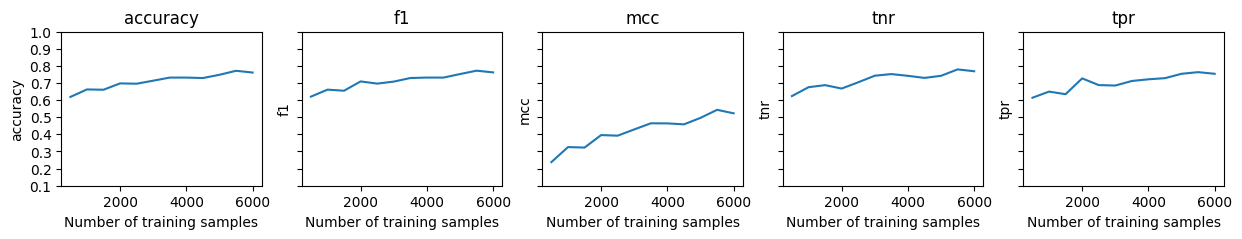

{500: {'accuracy': 0.6190000176429749, 'f1': 0.620517909526825, 'tnr': 0.6239432096481323, 'tpr': 0.6141965389251709, 'mcc': 0.23812001943588257}, 1000: {'accuracy': 0.6626666784286499, 'f1': 0.6615384817123413, 'tnr': 0.6756848096847534, 'tpr': 0.6500164270401001, 'mcc': 0.32573962211608887}, 1500: {'accuracy': 0.6610000133514404, 'f1': 0.6551373600959778, 'tnr': 0.687859296798706, 'tpr': 0.6348997950553894, 'mcc': 0.32310354709625244}, 2000: {'accuracy': 0.6980000138282776, 'f1': 0.7095223069190979, 'tnr': 0.667906641960144, 'tpr': 0.7272428274154663, 'mcc': 0.3959462344646454}, 2500: {'accuracy': 0.6961666941642761, 'f1': 0.696722686290741, 'tnr': 0.7044301629066467, 'tpr': 0.6881366968154907, 'mcc': 0.39254888892173767}, 3000: {'accuracy': 0.7138333320617676, 'f1': 0.7084394693374634, 'tnr': 0.7429827451705933, 'tpr': 0.6855077147483826, 'mcc': 0.4290120601654053}, 3500: {'accuracy': 0.7319999933242798, 'f1': 0.7293840646743774, 'tnr': 0.7524518370628357, 'tpr': 0.7121261954307556,

In [ ]:
print(results)

metrics = sorted(list(results[1000].keys()))
fig, subplots = plt.subplots(ncols=len(metrics), sharey=True, figsize=(15, 2))

for metric_index, metric in enumerate(metrics):
  to_plot_x, to_plot_y = zip(*[(num, results[num][metric]) for num in sorted(results.keys())])

  subplots[metric_index].plot(to_plot_x, to_plot_y)
  subplots[metric_index].set_title(metric)
  subplots[metric_index].set_ylabel(metric)
  subplots[metric_index].set_xlabel('Number of training samples')
  subplots[metric_index].set_yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

plt.show()
print(results)

In [ ]:
full_data_for_classfier = get_data_for_classifier()

results_file = os.path.join(sample_size_dir, 'results_d10df678-9164-4b3f-b6ce-d77c3331b552.json')

if not os.path.exists(results_file):
  with open(results_file, 'w') as f:
    f.write('{}')

with open(results_file, 'r') as f:
  results = json.load(f)

for model_name, model_str in [('BioBert', PRE_EXISTING_MODELS.BIO_BERT), ('sap-bert', PRE_EXISTING_MODELS.SAP_BERT), ('gatatron', PRE_EXISTING_MODELS.GATATRON), ]:

  tokenizer_dict = {
      'pretrained_string': model_str,
      'padding_side':'left',
      'truncate_side':'left',
      'do_lower_case':True
  }
  tokenizer = get_tokenizer(**tokenizer_dict)
  tokenizer_str = json.dumps(tokenizer_dict, sort_keys=True)

  if model_name not in results:
    results[model_name] = []
  for cross_fold_index, (train_val_df, test_df) in enumerate(get_balanced_cross_fold_train_test_split(
      full_data_for_classfier, 5)):
    if len(results[model_name]) > cross_fold_index: # we already have results
      print("Skipping %s cross fold index %d because we have results" % (model_name, cross_fold_index))
      continue

    train_dataset, validation_dataset = get_loader_cache(tokenizer, tokenizer_str, train_val_df)
    train_dataloader, validation_dataloader = define_dataloaders(train_dataset, validation_dataset)

    epochs = 4
    total_steps = len(train_dataloader) * epochs
    model = define_model(model_str)
    optimiser, scheduler = define_optimiser_and_scheduler(model)
    train(model, train_dataloader, validation_dataloader, optimiser, scheduler)
    test_loader = get_test_dataset(test_df)
    results[model_name].append(evaluate(model, test_loader))

    print(model_name)
    print(results[model_name])
    with open(results_file, 'w') as f:
      json.dump(results, f)
  print(results)

Entered function get_data_for_classifier
Exiting function get_data_for_classifier - took 0.20 seconds
Entered function get_tokenizer
Loading BERT tokenizer...
Exiting function get_tokenizer - took 0.92 seconds
Entered function get_balanced_cross_fold_train_test_split
Exiting function get_balanced_cross_fold_train_test_split - took 0.00 seconds
Skipping BioBert cross fold index 0 because we have results
Skipping BioBert cross fold index 1 because we have results
Skipping BioBert cross fold index 2 because we have results
Skipping BioBert cross fold index 3 because we have results
Skipping BioBert cross fold index 4 because we have results
{'BioBert': [{'accuracy': 0.7799999713897705, 'f1': 0.7788944840431213, 'tnr': 0.7850000262260437, 'tpr': 0.7749999761581421, 'mcc': 0.5600280165672302}, {'accuracy': 0.7741666436195374, 'f1': 0.7794955372810364, 'tnr': 0.75, 'tpr': 0.7983333468437195, 'mcc': 0.5489749312400818}, {'accuracy': 0.7808333039283752, 'f1': 0.777307391166687, 'tnr': 0.796666

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Exiting function get_tokenizer - took 0.59 seconds
Entered function get_balanced_cross_fold_train_test_split
Exiting function get_balanced_cross_fold_train_test_split - took 0.00 seconds
Entered function get_loader_cache


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  ADMISSION
Pt adm to MICU from RIH, on [**2127-1-25**] at [**2133**] for trachial stent placement in am. Pt had several weeksPt oriented to room. A&O x3, follows all commands. CM pattern s/r s/t with hr 90-120, Resident and intern in with pt to answer questions.Pt npo. IV, d5 [**12-19**] infusing at 150 hr.

Token IDs: tensor([    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,   

You are using a model of type megatron-bert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


pytorch_model.bin:   0%|          | 0.00/713M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UFNLP/gatortron-base and are newly initialized: ['bert.embeddings.LayerNorm.bias', 'bert.embeddings.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.10.attention.output.LayerNorm.bias', 'bert.encoder.layer.10.attention.output.LayerNorm.weight', 'bert.encoder.layer.10.output.LayerNorm.bias', 'bert.encoder.layer.10.output.LayerNorm.weight', 'bert.encoder.layer.11.attention.output.LayerNorm.bias', 'bert.encoder.layer.11.attention.output.LayerNorm.weight', 'bert.encoder.layer.11.output.LayerNorm.b

Exiting function define_model - took 4.94 seconds
Entered function train

======== Epoch 1 / 4 ========
Training...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  Batch    40  of    540.    Elapsed: 44.300710916519165.
  Batch    80  of    540.    Elapsed: 88.51730108261108.
  Batch   120  of    540.    Elapsed: 132.72234654426575.
  Batch   160  of    540.    Elapsed: 176.91475081443787.
  Batch   200  of    540.    Elapsed: 221.1029908657074.
  Batch   240  of    540.    Elapsed: 265.30495953559875.
  Batch   280  of    540.    Elapsed: 309.49387860298157.
  Batch   320  of    540.    Elapsed: 353.68317103385925.
  Batch   360  of    540.    Elapsed: 397.87222027778625.
  Batch   400  of    540.    Elapsed: 442.06385493278503.
  Batch   440  of    540.    Elapsed: 486.25200176239014.
  Batch   480  of    540.    Elapsed: 530.437397480011.
  Batch   520  of    540.    Elapsed: 574.6225373744965.

  Average training loss: 0.72
  Training epcoh took: 596.7072694301605

Running Validation...
  Accuracy: 0.48
  Validation Loss: 0.72
  Validation took: 21.49752950668335

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    540.    Elapse

KeyboardInterrupt: 